Loading relevant packages

In [3]:
import requests
import json
from json import loads
import pandas as pd
from datetime import datetime
import time
import loading
import util
import processing
import importlib
import itertools
importlib.reload(loading)
importlib.reload(util)
importlib.reload(processing)

/Users/jeremyelvander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<module 'processing' from '/Users/jeremyelvander/STA-141B-Final-Project/processing.py'>

Using BART API to find relevant station information (Station name, Lattitude & Longitude for mapping)

In [4]:
df = loading.stationLoad(["San Francisco", "Oakland"])


In [31]:
stationInfo = util.Rename(df, {"name":"station"})

In [5]:

dct = util.dfToDict(df, 'name', ['gtfs_latitude', 'gtfs_longitude'], groupby = 'city')
print(dct)
dct['San Francisco']['Balboa Park']

{'Oakland': {'12th St. Oakland City Center': [37.803768, -122.27145], '19th St. Oakland': [37.80835, -122.268602], 'Coliseum': [37.753661, -122.196869], 'Fruitvale': [37.774836, -122.224175], 'Lake Merritt': [37.797027, -122.26518], 'MacArthur': [37.829065, -122.26704], 'Oakland International Airport': [37.713238, -122.212191], 'Rockridge': [37.844702, -122.251371], 'West Oakland': [37.804872, -122.29514]}, 'San Francisco': {'16th St. Mission': [37.765062, -122.419694], '24th St. Mission': [37.75247, -122.418143], 'Balboa Park': [37.721585, -122.447506], 'Civic Center/UN Plaza': [37.779732, -122.414123], 'Embarcadero': [37.792874, -122.39702], 'Glen Park': [37.733064, -122.433817], 'Montgomery St.': [37.789405, -122.401066], 'Powell St.': [37.784471, -122.407974]}}


[37.721585, -122.447506]

In [6]:
secretKey = '1ef8dner8br348ez190z3z188a6pm1yluwh2wcj4xjjnlvupe'
key = '523e7ewewudxb1frvbmdftwdt'

In [7]:
importlib.reload(processing)
importlib.reload(util)
queriesSF = [
            ['SF', dct['San Francisco']['Balboa Park'], 0.25, 2021, 10, 0],
             ['SF', dct['San Francisco']['Embarcadero'], 0.25, 2021, 10, 0],
             ['SF', dct['San Francisco']['Glen Park'], 0.25, 2021, 10, 0],
            ['SF', dct['San Francisco']['Civic Center/UN Plaza'], 0.25, 2021, 10, 0],
            ['SF', dct['San Francisco']['24th St. Mission'], 0.25, 2021, 10, 0],
            ['SF', dct['San Francisco']['Montgomery St.'], 0.25, 2021, 10, 0],
            ['SF', dct['San Francisco']['16th St. Mission'], 0.25, 2021, 10, 0],
            ['SF', dct['San Francisco']['Powell St.'], 0.25, 2021, 10, 0]]

metaSF = [
    [['incident_category', "SF"],
    ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
    ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Balboa Park"},
    ["San Francisco", "Balboa Park", dct]],
 [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Embarcadero"},
    ["San Francisco", "Embarcadero", dct]],
[['incident_category', "SF"],
["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Glen Park"},
    ["San Francisco", "Glen Park", dct]],
 [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Civic Center/UN Plaza"},
    ["San Francisco", "Civic Center/UN Plaza", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "24th St. Mission"},
    ["San Francisco", "24th St. Mission", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Montgomery St."},
    ["San Francisco", "Montgomery St.", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "16th St. Mission"},
    ["San Francisco", "16th St. Mission", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Powell St."},
    ["San Francisco", "Powell St.", dct]]
]

subprocessesSF = [
    util.isViolent, 
    util.dayOrNight,
    util.splitColumnsJSON,
    util.splitColumnsJSON,
    util.addColumnsJSON,
    util.radius] * len(queriesSF)

queriesOAK = [
             ['OAK', dct['Oakland']['Fruitvale'], 0.25, 2021, 1000, 0],
             ['OAK', dct['Oakland']['Rockridge'], 0.25, 2021, 1000, 0],
             ['OAK', dct['Oakland']['MacArthur'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Coliseum'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['12th St. Oakland City Center'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Oakland International Airport'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Lake Merritt'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['19th St. Oakland'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['West Oakland'], 0.25, 2021, 1000, 0]
            ]

metaOAK = [
    [
        ['description', "OAK"],
    ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
        ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Fruitvale"},
    ["Oakland", "Fruitvale", dct]],
 [
     ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Rockridge"},
    ["Oakland", "Rockridge", dct]],
[
    ['description', "OAK"],
["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "MacArthur"},
    ["Oakland", "MacArthur", dct]],
 [
     ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Coliseum"},
    ["Oakland", "Coliseum", dct]],
    [
    ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "12th St. Oakland City Center"},
    ["Oakland", "12th St. Oakland City Center", dct]],
    [
        ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Oakland International Airport"},
    ["Oakland", "Oakland International Airport", dct]],
    [
    ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Lake Merritt"},
    ["Oakland", "Lake Merritt", dct]],
    [
        ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "19th St. Oakland"},
    ["Oakland", "19th St. Oakland", dct]],
    [
        ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "West Oakland"},
    ["Oakland", "West Oakland", dct]]
]

subprocessesOAK = [
    util.isViolent, 
    util.dayOrNight,
    util.splitColumnsJSON,
    util.splitColumnsJSON,
    util.addColumnsJSON,
    util.radius] * len(queriesOAK)

processes = [
    [processing.parallelProcess, [10, loading.loadCrime, queriesSF, 
                                       'crime', True, None, subprocessesSF,
                                       metaSF, key, secretKey]],
    [processing.parallelProcess, [10, loading.loadCrime, queriesOAK, 
                                       'crime', True, None, subprocessesOAK,
                                       metaOAK, key, secretKey]]
]

In [9]:
frame, thru, time = processing.parallelProcess(10, loading.loadCrime, queriesSF, 
                                       'crime', True, 20, subprocessesSF,
                                       metaSF, key, secretKey)
frame

[{'incident_datetime': '2021-01-06T15:00:00.000', 'incident_category': 'Burglary', 'point': {'type': 'Point', 'coordinates': [-122.39695784020824, 37.796346859010335]}}, {'incident_datetime': '2021-01-07T05:50:00.000', 'incident_category': 'Motor Vehicle Theft', 'point': {'type': 'Point', 'coordinates': [-122.39650448774395, 37.79309708139333]}}, {'incident_datetime': '2021-01-07T06:55:00.000', 'incident_category': 'Non-Criminal', 'point': {'type': 'Point', 'coordinates': [-122.39668969554637, 37.79046106747903]}}, {'incident_datetime': '2021-01-08T15:00:00.000', 'incident_category': 'Assault', 'point': {'type': 'Point', 'coordinates': [-122.3931813328012, 37.79323049132005]}}, {'incident_datetime': '2021-01-09T17:45:00.000', 'incident_category': 'Larceny Theft', 'point': {'type': 'Point', 'coordinates': [-122.39695784020824, 37.796346859010335]}}, {'incident_datetime': '2021-01-10T00:30:00.000', 'incident_category': 'Burglary', 'point': {'type': 'Point', 'coordinates': [-122.399763354

,incident_category,isViolent,night,longitude,latitude,date,time,city,station,distance
0,Larceny Theft,False,False,-122.444501,37.721096,2021-02-01,16:30:00.000,San Francisco,Balboa Park,0.208406
1,Other Miscellaneous,False,False,-122.443793,37.722240,2021-02-03,18:49:00.000,San Francisco,Balboa Park,0.257691
2,Recovered Vehicle,False,False,-122.443793,37.722240,2021-02-05,17:52:00.000,San Francisco,Balboa Park,0.257691
3,Other Miscellaneous,False,False,-122.443793,37.722240,2021-02-05,17:52:00.000,San Francisco,Balboa Park,0.257691
4,Drug Offense,False,False,-122.443793,37.722240,2021-02-05,17:52:00.000,San Francisco,Balboa Park,0.257691
...,...,...,...,...,...,...,...,...,...,...
155,Robbery,True,True,-122.410292,37.782231,2021-01-03,02:00:00.000,San Francisco,Powell St.,0.180376
156,Fraud,False,False,-122.408709,37.780971,2021-01-03,08:00:00.000,San Francisco,Powell St.,0.139188
157,Non-Criminal,False,False,-122.408952,37.783288,2021-01-03,08:35:00.000,San Francisco,Powell St.,0.080544
158,Suspicious Occ,False,False,-122.408493,37.784453,2021-01-03,14:41:00.000,San Francisco,Powell St.,0.035877


In [29]:
importlib.reload(processing)
importlib.reload(util)
importlib.reload(loading)


reviewQuery = [
    ['https://www.yelp.com/biz/muni-bart-station-embarcadero-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/muni-bart-station-montgomery-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-muni-powell-street-station-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/muni-bart-station-civic-center-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-16th-st-mission-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-24th-st-mission-station-san-francisco-2?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-glen-park-station-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-balboa-park-station-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-west-oakland-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-12th-street-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-19th-street-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-macarthur-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-rockridge-station-oakland-2?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-fruitvale-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-coliseum-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-lake-merritt-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-oakland-international-airport-station-oakland-2?sort_by=date_desc', True]
]

subprocessesReview = [
    util.reviewStationDict,
    util.getCompoundSentiment]* len(reviewQuery)

metaReview = [
    [['San Francisco', 'Embarcadero'],
     ['reviews']],
    [["San Francisco", "Montgomery St."],
     ['reviews']],
    [["San Francisco", "Powell St."],
     ['reviews']],
    [["San Francisco", "Civic Center/UN Plaza"],
     ['reviews']],
    [["San Francisco", "16th St. Mission"],
     ['reviews']],
    [["San Francisco", "24th St. Mission"],
     ['reviews']],
    [["San Francisco", "Glen Park"],
     ['reviews']],
    [["San Francisco", "Balboa Park"],
     ['reviews']],
    [["Oakland", "West Oakland"],
     ['reviews']],
    [["Oakland", "12th St. Oakland City Center"],
     ['reviews']],
    [["Oakland", "19th St. Oakland"],
     ['reviews']],
    [["Oakland", "MacArthur"],
     ['reviews']],
    [["Oakland", "Rockridge"],
     ['reviews']],
    [["Oakland", "Fruitvale"],
     ['reviews']],
    [["Oakland", "Coliseum"],
     ['reviews']],
    [["Oakland", "Lake Merritt"],
     ['reviews']],
    [["Oakland", "Oakland International Airport"],
     ['reviews']]
]

frame, thru, time = processing.parallelProcess(10, loading.GetReviews, reviewQuery, 
                                       'review', True, None, subprocessesReview, metaReview)
frame

done with visit list!
got da reviews
done with visit list!
review page done
review page done
done with visit list!
review page done
review page done
review page done
review page done
done with visit list!
review page done
review page done
review page done
review page done
review page done
done with visit list!
review page done
review page done
review page done
review page done
review page done
review page done
review page done
review page done
review page done
done with visit list!
review page done
review page done
review page done
review page done
review page done
review page done
review page done
done with visit list!
review page done
got da reviews
review page done
review page done
review page done
got da reviews
got da reviews
review page done
review page done
review page done
review page done
done with visit list!
review page done
review page done
review page done
review page done
review page done
review page done
review page done
review page done
review page done
review page done

,city,station,overallSentiment
0,San Francisco,Embarcadero,0.104858
1,San Francisco,Montgomery St.,0.170156
2,San Francisco,Powell St.,0.154613
3,San Francisco,Civic Center/UN Plaza,0.087766
4,San Francisco,16th St. Mission,0.043115
5,San Francisco,24th St. Mission,0.099162
6,San Francisco,Glen Park,0.339844
7,San Francisco,Balboa Park,0.116380
8,Oakland,West Oakland,0.000000
9,Oakland,12th St. Oakland City Center,0.102694


In [10]:

results = processing.multiParallelProcess(2, processes)

Time taken to process (seconds): 42.52286505699158
Time taken to process (seconds): 113.99345302581787


In [11]:
display(results[0][0].sample(5))
display(results[1][0].sample(5))

,incident_category,isViolent,night,longitude,latitude,date,time,city,station,distance
18865,Larceny Theft,False,False,-122.416292,37.777494,2022-12-23,23:59:00.000,San Francisco,Civic Center/UN Plaza,0.171246
35099,Burglary,False,False,-122.417568,37.749075,2023-06-06,15:30:00.000,San Francisco,24th St. Mission,0.131874
59351,Larceny Theft,False,False,-122.403712,37.784044,2021-10-01,15:51:00.000,San Francisco,Powell St.,0.294919
41041,Robbery,True,False,-122.398264,37.791716,2022-11-17,22:00:00.000,San Francisco,Montgomery St.,0.211637
10962,Malicious Mischief,False,False,-122.416292,37.777494,2021-09-13,22:50:00.000,San Francisco,Civic Center/UN Plaza,0.171246


,description,isViolent,night,longitude,latitude,date,time,city,station,distance
7780,inflict corporal injury on spouse/cohabitant,False,False,-122.19443,37.75309,2024-07-04,06:07:00.000,Oakland,Coliseum,0.169826
955,vehicle theft auto,False,True,-122.22108,37.77271,2022-08-07,02:55:00.000,Oakland,Fruitvale,0.227739
11055,burglary forcible entry,False,False,-122.26937,37.80189,2022-10-24,04:36:00.000,Oakland,12th St. Oakland City Center,0.159543
1231,vehicle theft auto,False,False,-122.22063,37.77431,2023-01-03,20:30:00.000,Oakland,Fruitvale,0.245704
14339,vehicle theft auto,False,False,-122.26717,37.80361,2024-06-14,07:30:00.000,Oakland,12th St. Oakland City Center,0.295780


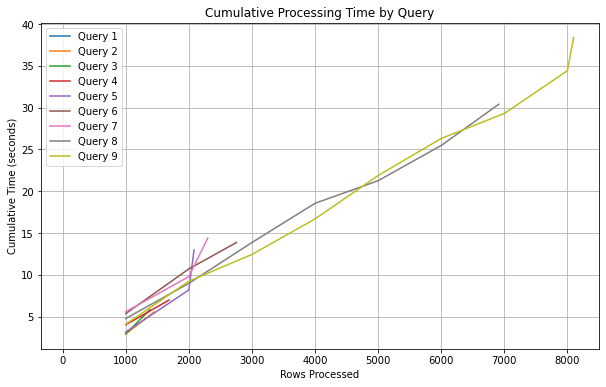

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

# Sample data
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = results[1][1]

# Number of queries
num_queries = len(data)

# Initialize storage for cumulative times and rows processed
cumulative_times = []
cumulative_rows = []

# Process each query
for query in data:
    # Extract processing times and rows processed for this query
    times = [entry[0] for entry in query]
    rows = [entry[1] for entry in query]

    # Calculate cumulative time and rows
    cumulative_times.append(np.cumsum(times))
    cumulative_rows.append(np.cumsum(rows))

# Plotting
plt.figure(figsize=(10, 6))

# Plot cumulative time for each query
for query_idx in range(num_queries):
    plt.plot(cumulative_rows[query_idx], cumulative_times[query_idx], label=f"Query {query_idx + 1}")

# Add labels, legend, and grid
plt.title("Cumulative Processing Time by Query")
plt.xlabel("Rows Processed")
plt.ylabel("Cumulative Time (seconds)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [18]:
names = {"incident_datetime": "datetime", "incident_category": "crime", "description": "crime"}
sfFrame =  util.Rename(results[0][0], names)
oakFrame = util.Rename(results[1][0], names)

crimeData = pd.concat([sfFrame, oakFrame], ignore_index = True)
crimeData['date'] = pd.to_datetime(crimeData['date']).dt.normalize()
crimeData['year'] = crimeData['date'].dt.year
crimeData['month'] = crimeData['date'].dt.month
crimeData['time'] = pd.to_datetime(crimeData['time']).dt.time
crimeData.sample(5)

,crime,isViolent,night,longitude,latitude,date,time,city,station,distance,year,month
25439,Drug Offense,False,False,-122.415505,37.781654,2023-12-07,22:55:00,San Francisco,Civic Center/UN Plaza,0.119118,2023,12
15740,Warrant,False,False,-122.413487,37.779992,2022-07-15,15:20:00,San Francisco,Civic Center/UN Plaza,0.044957,2022,7
15948,Drug Offense,False,False,-122.413487,37.779992,2022-07-23,14:59:00,San Francisco,Civic Center/UN Plaza,0.044957,2022,7
38106,Non-Criminal,False,False,-122.402190,37.790039,2021-03-21,15:12:00,San Francisco,Montgomery St.,0.081109,2021,3
89197,burglary auto,False,False,-122.272900,37.801570,2022-09-11,12:40:00,Oakland,12th St. Oakland City Center,0.128891,2022,9


In [19]:
# crimeData.groupby('station').size().reset_index(name = 'Number of Crimes')

result = (
    crimeData.groupby("station")
    .agg(
        crimes_per_station=("crime", "size"),  # Number of crimes per station
        most_common_crime=("crime", lambda x: x.mode()[0]),  # Most common crime
        percent_night=("night", lambda x: x.mean()),  # % crimes at night
        percent_violent=("isViolent", lambda x: x.mean()),  # % violent crimes
        avg_distance=("distance", "mean"),  # Average distance
    )
    .reset_index()
)
display(result)

,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance
0,12th St. Oakland City Center,6911,burglary auto,0.091014,0.121545,0.156881
1,16th St. Mission,11569,Larceny Theft,0.100787,0.158354,0.124127
2,19th St. Oakland,8097,burglary auto,0.087563,0.091639,0.147810
3,24th St. Mission,6670,Larceny Theft,0.105547,0.187406,0.120332
4,Balboa Park,896,Larceny Theft,0.111607,0.131696,0.158892
5,Civic Center/UN Plaza,23669,Drug Offense,0.074190,0.125396,0.133636
6,Coliseum,1452,vehicle theft auto,0.090909,0.115702,0.125075
7,Embarcadero,5240,Larceny Theft,0.055534,0.106298,0.146715
8,Fruitvale,2755,vehicle theft auto,0.109619,0.238475,0.148145
9,Glen Park,1264,Larceny Theft,0.079905,0.072785,0.140189


In [43]:
result = (
    crimeData.groupby(['year', 'month', 'station'])
    .agg(
        crimes_per_station=("crime", "size"),  # Number of crimes per station
        most_common_crime=("crime", lambda x: x.mode()[0]),  # Most common crime
        percent_night=("night", lambda x: x.mean()),  # % crimes at night
        percent_violent=("isViolent", lambda x: x.mean()),  # % violent crimes
        avg_distance=("distance", "mean"),  # Average distance
    )
    .reset_index()
)

result['year_month'] = (
    result['year'].astype(str) + '-' + result['month'].astype(str).str.zfill(2)
)

display(result.sample(5))

,year,month,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,year_month
500,2023,7,16th St. Mission,225,Larceny Theft,0.124444,0.155556,0.123551,2023-07
744,2024,9,Lake Merritt,25,vehicle theft auto,0.080000,0.160000,0.146081,2024-09
87,2021,6,Coliseum,37,vandalism,0.027027,0.135135,0.128502,2021-06
247,2022,3,Rockridge,42,vandalism,0.023810,0.071429,0.100098,2022-03
632,2024,2,Powell St.,380,Larceny Theft,0.084211,0.165789,0.132724,2024-02


<Figure size 864x432 with 0 Axes>

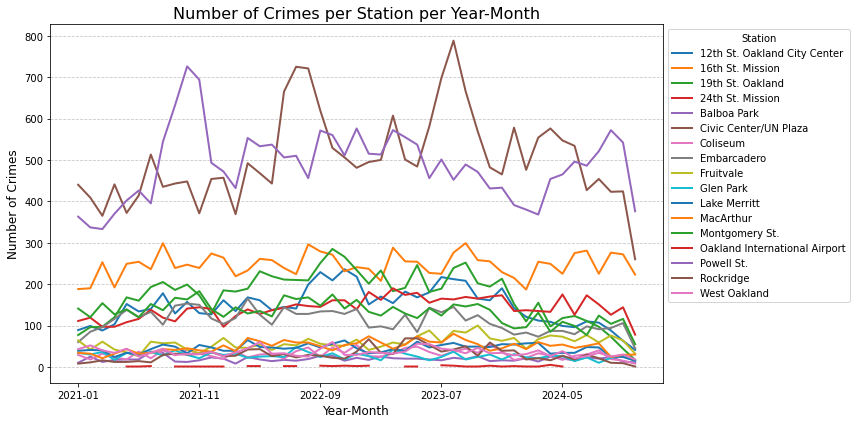

In [ ]:
import matplotlib.pyplot as plt

# Pivot the data to have stations as columns and year_month as rows
crime_summary = result.pivot(index='year_month', columns='station', values='crimes_per_station')

# Plot the data
plt.figure(figsize=(12, 6))
crime_summary.plot(linewidth=2, figsize=(12, 6))
plt.title('Number of Crimes per Station per Year-Month', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Station', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [44]:
merged = pd.merge(stationInfo, result, on="station")
merged.shape

(783, 12)

In [46]:
# Generate full combinations of years, months, and stations
years = merged["year"].unique()
months = range(1, 13)  # 12 months
stations = merged["station"].unique()
all_combinations = pd.DataFrame(list(itertools.product(years, months, stations)), columns=["year", "month", "station"])

# Merge with the original DataFrame
geoCrimeFrame = all_combinations.merge(merged, on=["year", "month", "station"], how="left")

# Fill missing values
geoCrimeFrame["crimes_per_station"].fillna(0, inplace=True)
geoCrimeFrame["most_common_crime"].fillna("None", inplace=True)  # No crime reported
geoCrimeFrame["percent_night"].fillna(0, inplace=True)
geoCrimeFrame["percent_violent"].fillna(0, inplace=True)
geoCrimeFrame["avg_distance"].fillna(0, inplace=True)

# Recreate 'year_month' column
geoCrimeFrame["year_month"] = geoCrimeFrame["year"].astype(str) + "-" + geoCrimeFrame["month"].astype(str).str.zfill(2)

# Sort the DataFrame by year, month, and station
geoCrimeFrame.sort_values(by=["year", "month", "station"], inplace=True)

# Reset index
geoCrimeFrame.reset_index(drop=True, inplace=True)

display(geoCrimeFrame)

,year,month,station,city,gtfs_latitude,gtfs_longitude,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,year_month
0,2021,1,12th St. Oakland City Center,Oakland,37.803768,-122.271450,89.0,burglary auto,0.067416,0.191011,0.142277,2021-01
1,2021,1,16th St. Mission,San Francisco,37.765062,-122.419694,188.0,Other Miscellaneous,0.111702,0.154255,0.125892,2021-01
2,2021,1,19th St. Oakland,Oakland,37.808350,-122.268602,77.0,burglary auto,0.038961,0.064935,0.127915,2021-01
3,2021,1,24th St. Mission,San Francisco,37.752470,-122.418143,111.0,Burglary,0.072072,0.090090,0.122344,2021-01
4,2021,1,Balboa Park,San Francisco,37.721585,-122.447506,10.0,Larceny Theft,0.000000,0.000000,0.156588,2021-01
...,...,...,...,...,...,...,...,...,...,...,...,...
811,2024,12,Montgomery St.,NaN,NaN,NaN,0.0,None,0.000000,0.000000,0.000000,2024-12
812,2024,12,Oakland International Airport,NaN,NaN,NaN,0.0,None,0.000000,0.000000,0.000000,2024-12
813,2024,12,Powell St.,NaN,NaN,NaN,0.0,None,0.000000,0.000000,0.000000,2024-12
814,2024,12,Rockridge,NaN,NaN,NaN,0.0,None,0.000000,0.000000,0.000000,2024-12


In [80]:
import plotly.express as px

geoCrimeFrame["scaled_crimes"] = geoCrimeFrame["crimes_per_station"] ** 0.5 
fig = px.scatter_mapbox(
    geoCrimeFrame,
    lat="gtfs_latitude",
    lon="gtfs_longitude",
    size="crimes_per_station",
    color="station",
    animation_frame="year_month",  # Animation over time
    hover_name="station",
    hover_data={"crimes_per_station": True, "most_common_crime": True, "percent_night": True, 
                "percent_violent": True, "avg_distance": True, "gtfs_latitude": False, "gtfs_longitude": False},
    mapbox_style="carto-darkmatter",  # Use a light map style
    zoom=11,  # Zoom level for the Bay Area
    title="Crime Trends Per Station Over Time",
)
fig.update_layout(
    height=750,  # Increase figure height
    width=1275   # Increase figure width
)


# Show the map
fig.show()